<img src="./img/HWNI_logo.svg"/>

# Tutorial A - Sampling and Bootstrapping

In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

# Introduction

In this tutorial, we'll work through the idea of bootstrapping for hypothesis testing. Since bootstrapping is so different from the other statistical tests we've learned about, we'll first work through some of the fundamental operations behind bootstrapping: working with random numbers on computers, generating random numbers with specific distributions, and resampling.

Then, we'll look at the motivation for and definition of bootstrapping, then visualize the bootstrap in action in a case where we can visualize the process. This will help us build intuition for why bootstrapping, which strikes many folks as counterintuitive, actually works.

In Lab A, we'll visualize some more key components of bootstrapping: the cumulative distribution functions of the population, data, and bootstrap samples. We'll also apply bootstrapping to some one-sample tests.

In Tutorial B, the concept of correlation between random variables will be introduced, and its uses and limits examined.

In Lab B, we'll work on calculating the correlation in Python and then perform some hypothesis testing on the correlation using bootstrapping.

# Generating Random Numbers

## Computers and Randomness

In [2]:
np.random.standard_normal() #magic?

-0.6859300899262211

With a single command above, we are able to ask Python for a number whose exact value we seem to be unable to predict, but whose probability distribution we can describe. If we were really unable to predict that value, we'd say that it is *random*. You can see this for yourself by running the cell above repeatedly. Different numbers come out each time!

But computers do not behave randomly -- randomness comes from factors that we do not control, and we have very intentionally designed computers in such a way that their macroscopic behavior is essentially unaffected by the factors that we do not control.

Instead, computers behave like functions: if you know their inputs, then you can figure out their outputs. 

Already in this course, we've need to generate "random" outputs -- a random shuffling of the labels of our data for our randomization tests, for instance. Trouble is, if someone knows everything about the state of our computer, then they can perfectly reproduce the so-called "random" outputs. For statisticians, this turns out to be a problem that's more philosophical than practical -- if we don't know the exact state of our computer, then it *might as well be random* from our perspective. For cryptography, which relies on randomness, this distinction is critical.

This problem is usually solved by measuring something outside of our (easy) control -- the ones digit of the current time in milliseconds or the fifth decimal point of the temperature of the CPU. This number is then used to generate a very long sequence of numbers that have no obvious relationship between them. So long as we don't specifically control the measurement, the resulting output will appear random to us, and all of your statistical operations that rely on randomness will work.

The operation described above is called "seeding" the random number generator. It normally happens when we start using the random parts of numpy or Python, but we can ask for it to happen at any time by using the function `np.random.seed()` (with no arguments).

Run the cell below. Notice that the output is different each time!

In [3]:
np.random.seed()
np.random.standard_normal()

0.21261239450956454

We don't have to use a measurement as our seed. If we provide a (positive) number, Python will happily use that to seed the random number generator. In contrast to the previous cell, running this cell repeatedly will always generate the same result.

In [4]:
np.random.seed(5091991)

np.random.standard_normal()

1.9649959891356643

Now, let's ask Python for another random value using the same function.

In [5]:
np.random.standard_normal()

1.1793638143360363

This number is different from the one generated by the cell with the seed in it, but it's the same if you run the cells one after the other (try it!).

The practical upshot of this is that, if you want, you can make all the code you run *reproducible*, so that someone running your code will get the same thing on their computer, even if it includes a "random" component. For example, if you perform a randomization-based analysis of your data and then make your code publicly available, seeding will allow others to directly replicate your results.

## Random Numbers in Python

The numpy library offers just about all of the random number functionality we need for this course. So we proceed after a quick **WARNING**: numpy is not "random enough" to be used in cryptography. If you make a billion-dollar website, don't use numpy for security-critical components.

Numpy's random functions are nice because they are designed to produce lots of random numbers at once. We simply tell numpy the dimensions of the array of random numbers that we want, and it returns it to us.

In [6]:
random_vector = np.random.standard_normal((10,1)) # 10 by 1 random vector
print(random_vector)
print('')

random_matrix = np.random.standard_normal((3,3)) # 3 by 3 random matrix
print(random_matrix)
print('')

random_block = np.random.standard_normal((2,2,2)) # 2 by 2 by 2 random block
print(random_block)
print('')

[[ 0.0053099 ]
 [ 0.2859743 ]
 [-0.4813776 ]
 [-2.59799308]
 [-0.1747445 ]
 [-1.14679415]
 [ 1.31048956]
 [-3.27292125]
 [-0.96528963]
 [-0.26869865]]

[[ 0.117913    0.10455175  0.39234959]
 [ 2.88744766  0.44964858 -0.59689339]
 [-0.96484926  1.18136532  1.09414916]]

[[[ 0.83665013 -1.43010054]
  [ 1.03967813 -0.29965665]]

 [[ 1.02348257 -0.59982409]
  [ 0.49957053  0.75052964]]]



We can confirm that the distribution of these numbers is, in fact, approximately normal by plotting it.

The cell below generates a large number of samples from a random normal distribution
and uses seaborn's `distplot` to visualize it.
I have a preferred style for plotting distributions that differs
slightly from the defaults of `distplot`,
so to save myself the trouble of repeatedly calling it with those arguments,
I write my own function,
`plot_distribution`,
that just calls `distplot` with my preferred settings.
This is a good trick for reducing the amount you have to repeat yourself when coding!

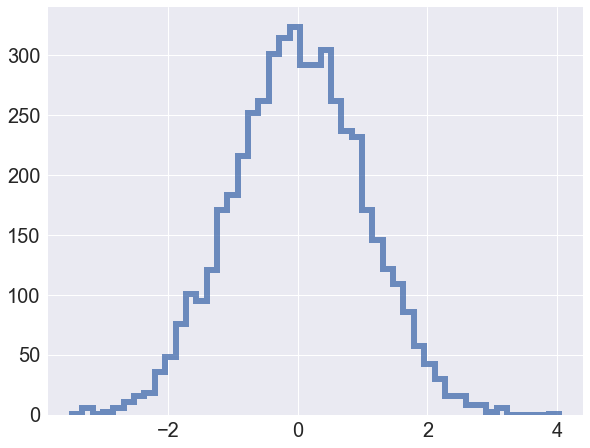

In [7]:
normal_sample = np.random.standard_normal(5000)

def plot_distribution(samples,discrete=False):
    
    hist_kws = {'histtype':'step',
            'linewidth':6,
               'alpha':0.8}
    
    #kde_kws = {'linewidth':4,}
    
    if discrete:
        mini = min(samples)
        maxi = max(samples)
        bins = range(mini,maxi+1)
        sns.distplot(samples, kde=False,
             hist_kws=hist_kws,
             bins=bins);
    else:
        sns.distplot(samples,kde=False,
             hist_kws=hist_kws,
            );

plt.figure()
plot_distribution(normal_sample)

`numpy.random.standard_normal` generates samples from the *standard normal distribution*, the normal (aka Gaussian) distribution with a mean of zero and a standard deviation of 1.

If we want normal random variables with a different mean and standard deviation, we simply multiply by the desired standard deviation and then add the desired mean.

Below, generate another normally-distributed random vector with a different mean and standard deviation and plot the two on the same plot using `distplot`.

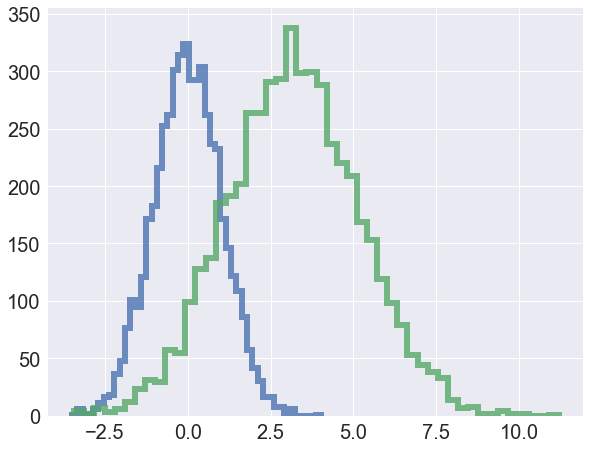

In [8]:
other_normal_vector = 2*np.random.standard_normal(5000)+3.2

plt.figure()
plot_distribution(normal_sample)
plot_distribution(other_normal_vector)

### Estimating the Sampling Distribution

In the past, we've performed our hypothesis testing by formulating a *test statistic*
and using knowledge of the *sampling distribution of that statistic*.
In most of our tests,
including the $F$-test and the $t$-test,
this involved taking advantage of the pre-calculated sampling distributions
for cleverly chosen test statistics ($F$ and $t$)
provided by Python's scipy libraries.
For other tests,
like the randomization test,
that involved being able to draw lots of samples from the sampling distribution of the statistic
under the null hypothesis.

Bootstrap hypothesis testing will be based on approximately drawing samples from the
actual sampling distribution of the statistic,
without having to either specify a null distribution for the data
or for the test statistic.
This makes the bootstrap flexible and easy to implement.

Before we learn how that is done,
let's first use sampling to estimate the sampling distribution of some statistics.

Recall that a statistic is any function of the data.
Useful statistics usually *summarize* the data,
meaning that they take in an entire dataset and spit out a much smaller set of numbers.
For example, the mean is a single number,
while the four quartiles of a dataset are four numbers.

To get the sampling distribution of a statistic,
we first draw a sample of some size,
then we calculate the statistic.
This is one sample from the sampling distribution of the statistic.
We repeat this many times in order to get a good estimate of the sampling distribution.

We can visualize the sampling distribution of one-dimensional statistics using `distplot`,
as in the cell below.
The first two lines determine how large samples are (`sample_size`)
and how many samples we draw (`num_samples`).
The next two lines determine which random number generator we choose,
the `sampler`,
and which function we use to calculate the statistic,
the `statistic`.
Note that both variables are actually *functions*,
so we write

```
sampler = np.random.standard_normal
```

rather than

```
sampler = np.random.standard_normal
```

The next two lines first draw the samples
and then calculate the statistic for each sample
using list comprehensions.

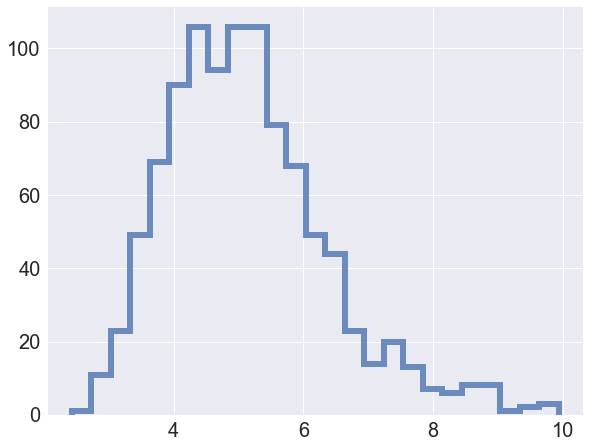

In [9]:
num_samples = 1000
sample_size = 100

sampler = np.random.standard_exponential
statistic = np.max

samples = [sampler(size=sample_size) for _ in range(num_samples)]
statistics = [statistic(sample) for sample in samples]

plt.figure();
plot_distribution(statistics)

You should try a few different samplers,
like `np.random.standard_exponential`
and `np.random.standard_cauchy`
and a few different statistics,
like
`np.max` and `np.min`,
`np.mean`,
and
`np.prod` (with a small sample size, like 3 or 4).

While many of these sampling distributions are simple,
even Gaussian,
others seem harder to describe.
When we get to even more exotic statistics,
like the parameters of models fit to large datasets,
methods based on being able to calculate the sampling distribution,
like $t$-testing and ANOVA,
will be few and far between.
Bootstrapping and randomization tests will be the only option in many of these cases.

## Bootstrapping

The ideal way to estimate the sampling distribution of a statistic would be to repeat the experiment
that generates the statistic over and over again,
calculating the statistic anew for each dataset.

This isn't a good idea in practice for at least two reasons:
first, practically, we usually select our sample sizes because we are limited for 
financial, computational, or ethical reasons,
and collecting many samples of that size would violate those constraints.
Second, statistically,
we'd like to make our inferences about hypotheses or parameters
using as much data as possible,
so splitting our sample into many equally sized chunks
just in order to be able to build confidence intervals or calcualte $p$ values
seems inefficient.

The key idea of *bootstrapping* is as follows:

<p {style="text-align: center"}> **the best generic guess for the true sampling distribution of a statistic is 
<br>the distribution we get when we calculate the statistic from repeated samples from our data** </p>

That is, if we want to estimate the sampling distribution of some statistic $f$
and we know nothing about the true distribution of the data,
(e.g. we don't know if it's Gaussian)
the best we can do is to repeatedly sample from the data with replacement,
recalculating $f$ each time and storing the result.
Estimating this sampling distribution then also lets us estimate things like
confidence intervals and $p$ values.

This procedure strikes some folks as odd,
even counterintuitive:
how can I expect to get information about how
my statistic would vary if I took different data
using only data I've observed?

In fact, the name "bootstrapping" reflects this very counterintuition:
it refers to the idea of
[pulling oneself up by one's own bootstraps](https://en.wiktionary.org/wiki/pull_oneself_up_by_one%27s_bootstraps),
an 18th century idiom for achieving an impossible task.
The bootstraps are the tiny pieces of cloth or leather that stick from the back of some boots,
and to pull onself up by one's own bootstraps is to leap over a large obstacle simply by tugging on them,
a physical impossibility.

Bootstrapping seems similarly impossible:
without any external aid save our data,
we are attempting to draw inferences about the sampling distribution of a statistic.
Put another way,
we've only seen one draw from the sampling distribution,
namely the statistic we calculated from our data,
but we're claiming to be able to infer the structure of the whole distribution.

Rigorously proving that bootstrapping works is beyond the scope of this course,
so instead let's try and gain some intuition for why it might work.

### Visualizing Bootstrapping with Histograms

First, let's visualize the result of bootstrap sampling.
Since the goal of bootstrapping is to mimic the result
of sampling again from the population distribution,
let's compare the result of repeated bootstrap sampling
to the result of repeatedly sampling from the underlying population distribution.

The function `plot_bootstrap` will take a `sampler` that samples from some population distribution
and a function `pdf` that represents that distribution and,
if the argument `plot_samples` is `True`, plot the following:

- The probability density function of the population. This is the distribution that our original data sample is drawn from.
- A histogram of the original data sample. This is the distribution that our bootstrap samples are drawn from. As `num_samples` gets larger, this should get closer to the population distribution.
- Many histograms of other samples from the population. These represent the outcomes of additional identical experiments. We'd like our bootstrap samples to be almost indistinguishable from these samples.
- Many histograms of bootstrap samples from the original data sample. If these overlap well with the histograms of the other data samples, then our bootstrap samples look like they are new draws from the population distribution, and we can calculate the statistic from each of those samples to get a good estimate of the sampling distribution.

This cell can also be run with `sampler` set to `np.random.standard_exponential`
and `pdf` set to `scipy.stats.expon().pdf`
or with `sampler` set to `np.random.lognormal`
and `pdf` set to `scipy.stats.lognorm(s=1).pdf`,
if you'd like to see an example that's not Gaussian.

Run the cell below with different choices for `num_samples`.
Start with `100`,
and ask yourself whether the bootstrap sample histograms look like
the other data sample histograms.
Increase `num_samples` to `5000`, then decrease it to `10`,
and ask whether that's still the case.

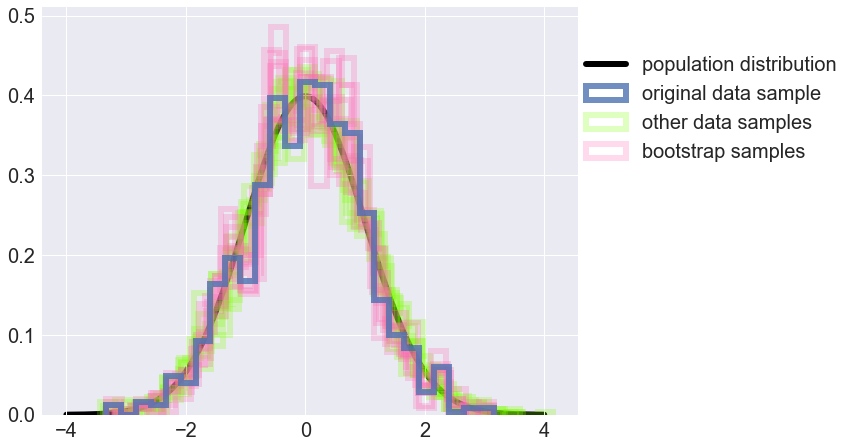

In [144]:
num_samples = 1000

sampler = np.random.standard_normal
pdf = scipy.stats.norm().pdf

plot_bootstrap(sampler=sampler, pdf = pdf,
               plot_samples=True, plot_statistic=False,
              num_samples=num_samples)

The histogram of the original data sample approximates something called the
*empirical distribution* --
*empirical* because it is derived directly from the data,
with no intermediary assumptions,
and *distribution* because it describes the distribution of a random variable.
The random variable whose distribution it describes is the random variable
we sample when bootstrapping:
the distribution for values drawn from our data.
We will discuss this distribution in great detail in the first lab for this section.

### Vizualizing the Bootstrapped Sampling Distribution

Now, let's visualize the output of bootstrapping:
the bootstrap-estimated sampling distribution of the statistic.

The purpose of generating these new bootstrap samples
that look like samples from the population distribution
is in order to estimate the sampling distribution.
Normally, we do bootstrapping when we don't know this distribution.
If we stick to a case where we do --
the sampling distribution of the mean of Gaussian data is a Gaussian distribution --
we can compare the bootstrap sample means
and the sample means of other samples from the population
to the ground truth
to get a sense of how and when bootstrapping works.

If run with arguments as below, `plot_bootstrap` will plot the following:

- the mathematically-derived sampling distribution of the mean of the data (a Gaussian).
- a histogram of the means of `num_alternates` samples taken according to the `sampler`. This is an approximation of the sampling distribution of the mean.
- a histogram of the means of `num_bootstraps` bootstrap samples from the original data sample. We hope that this histogram looks similar to the histogram of the means of the other data samples.
- the value of the mean of the original data sample. If were to draw approximate 95% error bars based on our bootstrap, we'd place them around this value and 

Run the cell below and determine whether you think the bootstrap is working well for this example.

The true value of the mean is $0$ in this case.
We test the hypothesis that it is different from $0$
at a confidence level of 95%
by asking whether 95% or more of the mass is above $0$,
otherwise we say that we fail to reject the hypothesis that the mean is $0$.
Does this test appear to correctly fail to reject the hypothesis that the mean is $0$ most of the time?

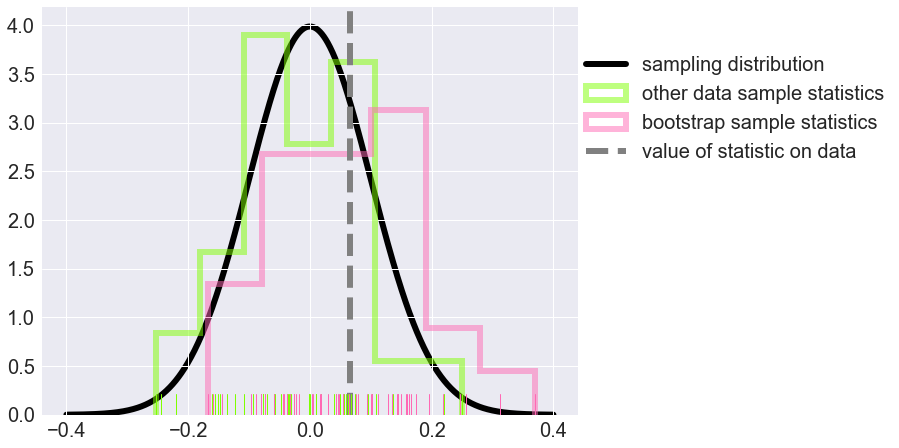

In [150]:
num_samples = 100

sampler = np.random.standard_normal
pdf = scipy.stats.norm().pdf

plot_bootstrap(sampler=sampler, pdf = pdf,
               plot_samples=False, plot_statistic=True,
              num_samples=num_samples, num_bootstraps=50, num_alternates=50)

We'll visualize bootstrapping in another way in the first lab for this section,
and then we'll apply bootstrapping to testing the hypothesis that the sample mean is different from $0$.

In the other tutorial for this section,
we cover the correlation,
which will help us cross the bridge from hypothesis-testing to data-modeling,
which will be the subject of the rest of the course.
The second lab for this section will look at calculating the correlation for various models
and using bootstrapping to establish error bars on the correlation.

## Bootstrap Sampling in Python

The random number generating functions discussed at the beginning of this tutorial will be useful when we want to simulate a data-generating process. For example, I've used them to make the simulated data for the labs in this course.

In bootstrapping, however, we don't sample from a parametrized distribution, as we did in the beginning of this tutorial. Instead, we sample from our data directly. If you were to implement this by hand, drawing a single sample might look something like this:

1. Write down all of the data values on pieces of paper.
1. Put the pieces of paper in a hat.
1. Shake the hat up and blindly draw a single slip.
1. The value on that slip is the value you sampled.

When bootstrapping, we draw our samples "with replacement", which is to say that, if we wanted to draw more than one sample, we'd add two more steps. In step 5, we'd put the slip we drew back in, and then in step 6, we'd repeat steps 3-5 until we had enough samples.

In numpy, sampling from a 1-D array with or without replacement is implemented with the function `np.random.choice`. In the cell below, we generate a dataset using one of the sampling functions above, then print it, and then sample from it, with replacement, using `np.random.choice`.

In [151]:
data = np.random.poisson(size=10)
print(data)

for _ in range(10):
    resample = np.random.choice(data,size=1)
    print(resample)

[1 2 1 0 0 0 2 0 0 1]
[2]
[1]
[0]
[1]
[0]
[0]
[2]
[0]
[0]
[0]


`np.random.choice` is designed for 1-D datasets. For datasets that are 2-D or larger, we instead use `np.random.randint(low,high)`, which generates a random integer at least as big as `low` but less than `high`. When `low` is 0 and `high` is the length of the dataset, we can use the resulting list to index into the data array, taking an entire row or entire column for each random index.

In [152]:
data = np.vstack([np.random.poisson(size=10),
                  np.random.choice(["A","B","C"],size=10)])
print(data)

for _ in range(10):
    random_indices = np.random.randint(0,len(data),size=3)
    resample = data[:,random_indices]
    print(resample)

[['0' '0' '0' '0' '1' '4' '2' '1' '1' '3']
 ['C' 'A' 'C' 'A' 'A' 'A' 'C' 'B' 'C' 'C']]
[['0' '0' '0']
 ['A' 'C' 'C']]
[['0' '0' '0']
 ['C' 'A' 'A']]
[['0' '0' '0']
 ['C' 'C' 'A']]
[['0' '0' '0']
 ['A' 'A' 'A']]
[['0' '0' '0']
 ['C' 'C' 'C']]
[['0' '0' '0']
 ['A' 'A' 'A']]
[['0' '0' '0']
 ['A' 'A' 'A']]
[['0' '0' '0']
 ['C' 'C' 'A']]
[['0' '0' '0']
 ['A' 'C' 'A']]
[['0' '0' '0']
 ['A' 'C' 'A']]
